In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
url = 'https://budget.canada.ca/2024/report-rapport/overview-apercu-en.html#a1'

In [3]:
page = requests.get(url)

soup = BeautifulSoup(page.text, 'html')

In [4]:
inflation_table = soup.find_all('table')[4]

In [5]:
inflation_head = inflation_table.find_all('th')

In [7]:
inflation_head_list = []

for i, title in enumerate(inflation_head):
    if i < 4:
        inflation_head_list.append(title.text.replace('\n', '').replace('\t', '').replace('\r', '').strip())
    else:
        break

In [8]:
df = pd.DataFrame(columns = inflation_head_list)

In [9]:
inflation_column_data = inflation_table.find_all('tr')

In [10]:
for row in inflation_column_data[1:]:
    # Find the <th> element if it exists
    inflation_header = row.find('th')
    
    # Initialize a list to hold the row data
    individual_inf_row_data = []
    
    # If there is a <th>, add its text to the list
    if inflation_header:
        individual_inf_row_data.append(inflation_header.text.strip())
    
    # Find all <td> elements and add their text to the list
    inflation_row_data = row.find_all('td')
    individual_inf_row_data.extend([data.text.strip() for data in inflation_row_data])

    length = len(df)
    df.loc[length] = individual_inf_row_data

In [11]:
df

,,Average of core inflationmeasures,Total CPI excluding mortgageinterest cost,2% inflation
0,Jan 2019,1.8,1.2,2
1,Feb 2019,1.9,1.3,2
2,Mar 2019,2.1,1.7,2
3,Apr 2019,2.0,1.8,2
4,May 2019,2.1,2.2,2
...,...,...,...,...
57,Oct 2023,3.5,2.2,2
58,Nov 2023,3.5,2.2,2
59,Dec 2023,3.6,2.5,2
60,Jan 2024,3.4,2.0,2


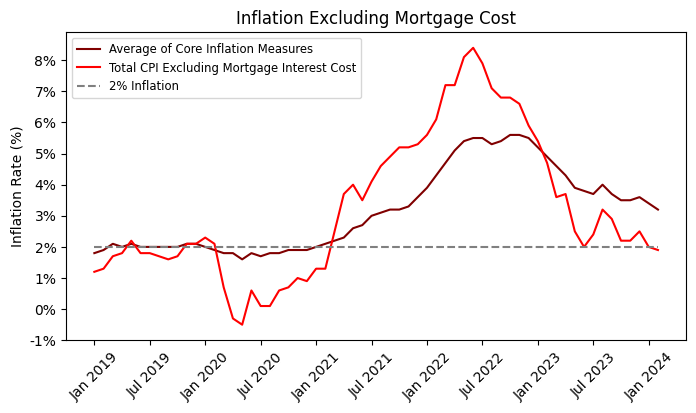

In [13]:
df = df.rename(columns={df.columns[0]: 'Date'})

df['Average of core inflationmeasures'] = pd.to_numeric(df['Average of core inflationmeasures'], errors='coerce')
df['Total CPI excluding mortgageinterest cost'] = pd.to_numeric(df['Total CPI excluding mortgageinterest cost'], errors='coerce')
df['2% inflation'] = pd.to_numeric(df['2% inflation'], errors='coerce')

#changing the date to datetime format for numeric calculations
df['Date'] = pd.to_datetime(df['Date'], format='%b %Y', errors='coerce')
df['Date'] = df['Date'].dt.strftime('%b %Y')

#sizing the graph
plt.figure(figsize=(8, 4))

# plot each column
plt.plot(df['Date'], df['Average of core inflationmeasures'], label='Average of Core Inflation Measures', color='maroon')
plt.plot(df['Date'], df['Total CPI excluding mortgageinterest cost'], label='Total CPI Excluding Mortgage Interest Cost', color='red')
plt.plot(df['Date'], df['2% inflation'], label='2% Inflation', linestyle='--', color='gray')

# set the title and labels
plt.title('Inflation Excluding Mortgage Cost')
plt.ylabel('Inflation Rate (%)')

# x-axis: Shows every 6th month
plt.xticks(ticks=df['Date'][::6], rotation=45) 

max_y = df[['Average of core inflationmeasures', 'Total CPI excluding mortgageinterest cost']].max().max()
plt.ylim(-1, max_y + 0.5)  # add a small margin above the highest data point

#formatting the y-axis 
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))  # Set major ticks at intervals of 1%
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}%'))


plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(0, 1))
plt.show()

In [14]:
rent_table = soup.find_all('table')[6]

In [15]:
rent_head = rent_table.find_all('th')

In [17]:
rent_heading = ['Year', 'Rent Inflation (%)']
df = pd.DataFrame(columns = rent_heading)

In [18]:
rent_head_list = []

for i, title in enumerate(rent_head):
    if i < 2:
        rent_head_list.append(title.text.replace('/', ' ').strip())
    else:
        break

In [19]:
rent_column_data = rent_table.find_all('tr')

In [20]:
for row in rent_column_data[1:]:
    rent_header = row.find('th')
    
    individual_rent_row_data = []
    
    if rent_header:
        cleaned_text = re.sub(r'[-/]', ' ', rent_header.text).strip()
        individual_rent_row_data.append(cleaned_text)
    
    rent_row_data = row.find_all('td')
    individual_rent_row_data.extend([data.text.strip() for data in rent_row_data])

    length = len(df)
    df.loc[length] = individual_rent_row_data

In [21]:
df

,Year,Rent Inflation (%)
0,Feb 1981,5.6603774
1,Mar 1981,5.6485356
2,Apr 1981,5.8455115
3,May 1981,6.25
4,Jun 1981,6.2240664
...,...,...
512,Oct 2023,8.2413539
513,Nov 2023,7.4181818
514,Dec 2023,7.7480087
515,Jan 2024,7.9


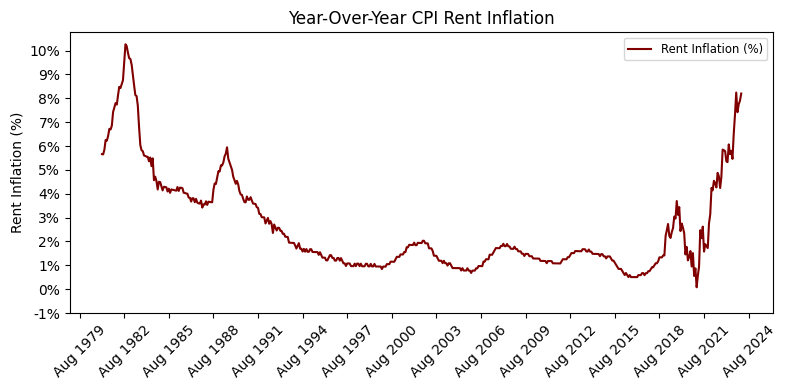

In [22]:
df.columns = ['Year', 'Rent Inflation (%)']
df['Rent Inflation (%)'] = pd.to_numeric(df['Rent Inflation (%)'], errors='coerce')

#changing the date to datetime format for numeric calculations
df['Year'] = pd.to_datetime(df['Year'], format='%b %Y', errors='coerce')

#sizing the graph
plt.figure(figsize=(8, 4))

plt.plot(df['Year'], df['Rent Inflation (%)'], label='Rent Inflation (%)', color='maroon')

# Set title and labels
plt.title('Year-Over-Year CPI Rent Inflation')
plt.ylabel('Rent Inflation (%)')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=36))

plt.xticks(rotation=45)

# Calculate the maximum y value
max_y = df['Rent Inflation (%)'].max()
plt.ylim(-1, max_y + 0.5)  # Add a small margin above the highest data point

# Formatting the y-axis 
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))  # Set major ticks at intervals of 1%
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}%'))

plt.legend(loc='upper right', fontsize='small', bbox_to_anchor=(1, 1))
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

In [23]:
unemployment_table = soup.find_all('table')[8]

In [24]:
unemployment_head = unemployment_table.find_all('th')

In [25]:
unemployment_head_list = []

for i, title in enumerate(unemployment_head):
    if i < 3:
        unemployment_head_list.append(title.text.replace('-', ' ').strip())
    else:
        break

In [26]:
df = pd.DataFrame(columns = unemployment_head_list)

In [27]:
unemployment_column_data = unemployment_table.find_all('tr')

In [28]:
for row in unemployment_column_data[1:]:
    unemployment_header = row.find('th')

    individual_unem_row_data = []
    
    if unemployment_header:
        individual_unem_row_data.append(unemployment_header.text.replace('-', ' ').strip())

    unemployment_row_data = row.find_all('td')
    individual_unem_row_data.extend([data.text.strip() for data in unemployment_row_data])

    length = len(df)
    df.loc[length] = individual_unem_row_data

In [29]:
df

,,Unemployment Rate,Current rate
0,Jan 1976,7.1,6.1
1,Feb 1976,7.0,6.1
2,Mar 1976,6.7,6.1
3,Apr 1976,6.8,6.1
4,May 1976,6.9,6.1
...,...,...,...
574,Nov 2023,5.8,6.1
575,Dec 2023,5.8,6.1
576,Jan 2024,5.7,6.1
577,Feb 2024,5.8,6.1


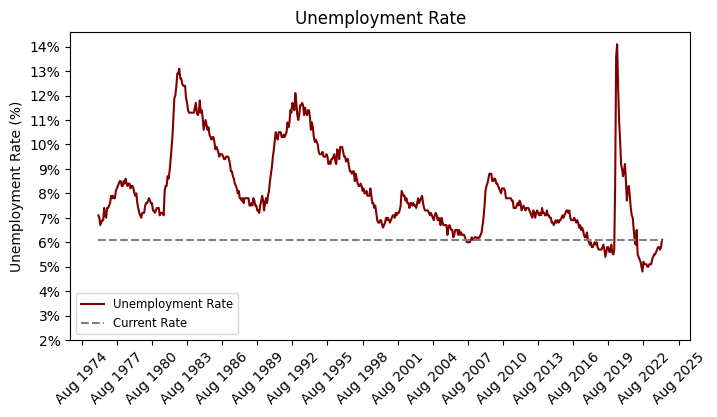

In [30]:
df = df.rename(columns={df.columns[0]: 'Date'})

df['Unemployment Rate'] = pd.to_numeric(df['Unemployment Rate'], errors='coerce')
df['Current rate'] = pd.to_numeric(df['Current rate'], errors='coerce')

#changing the date to datetime format for numeric calculations
df['Date'] = pd.to_datetime(df['Date'], format='%b %Y', errors='coerce')

#sizing the graph
plt.figure(figsize=(8, 4))

# plot each column
plt.plot(df['Date'], df['Unemployment Rate'], label='Unemployment Rate', color='maroon')
plt.plot(df['Date'], df['Current rate'], label='Current Rate', linestyle='--', color='gray')

# set the title and labels
plt.title('Unemployment Rate')
plt.ylabel('Unemployment Rate (%)')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=36))

plt.xticks(rotation=45) 

max_y = df[['Unemployment Rate', 'Current rate']].max().max()
plt.ylim(2, max_y + 0.5)  # add a small margin above the highest data point

#formatting the y-axis 
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1))  # Set major ticks at intervals of 1%
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}%'))

plt.legend(loc='lower left', fontsize='small', bbox_to_anchor=(0, 0))
plt.show()